In [1]:
# import new_adventure as na
# import new_adventure.derivative_free_estimation as dfe
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import yaml
import pickle

from utils import convert_opt_path

%load_ext autoreload
%autoreload 2

def load_opt_path(experiment_folder, process_id):
    with open(os.path.join(experiment_folder, process_id, "results.pkl"), "rb") as f:
        all_paths = pickle.load(f)
    return all_paths

In [5]:
# exp_path = "/Users/daniellengyel/new_adventure/experiments/linear/"
# exp_path = "/rds/general/user/dl2119/home/new_adventure/experiments/linear/"
exp_path = "/vol/bitbucket/dl2119/new_adventure/experiments/linear/"

bfgs_folder = "Newton_IPM_Jun05_11-26-24_kingfisher.doc.ic.ac.uk"
bfgs_id = "1622888784.369538"
bfgs_path = load_opt_path(exp_path + bfgs_folder, bfgs_id)

newton_folder = "Newton_IPM_Jun05_00-46-17_kingfisher.doc.ic.ac.uk"
newton_id = "1622850377.0825555"
newton_path = load_opt_path(exp_path + newton_folder, newton_id)

shift_folder = "Newton_shift_est_IPM_Jun05_00-39-06_kingfisher.doc.ic.ac.uk"
shift_id = "1622849946.8173707"
shift_path = load_opt_path(exp_path + shift_folder, shift_id)

# shift_multi_folder = "BFGS_Jun04_17-53-27_kingfisher.doc.ic.ac.uk"
# shift_multi_id = "1622825607.1867328"
# shift_multi_path = load_opt_path(exp_path + shift_multi_folder, shift_multi_id)

In [6]:


bfgs_vals = convert_opt_path(bfgs_path)
bfgs_vals[:, 1] -= bfgs_vals[1, 1]
newton_vals = convert_opt_path(newton_path)
newton_vals[:, 1] -= newton_vals[1, 1]
shift_vals = convert_opt_path(shift_path)
shift_vals[:, 1] -= shift_vals[1, 1]
# shift_multi_vals = convert_opt_path(shift_multi_path)


# bfgs_vals = np.array([[[np.sum(p[i][0]), p[i][1]] for i in range(len(p))] for p in bfgs_path ]).reshape(-1, 2)
# newton_vals = np.array([[[np.sum(p[i][0]), p[i][1]] for i in range(len(p))] for p in newton_path ]).reshape(-1, 2)
# shift_vals = np.array([[[np.sum(p[i][0]), p[i][1]] for i in range(len(p))] for p in shift_path ]).reshape(-1, 2)

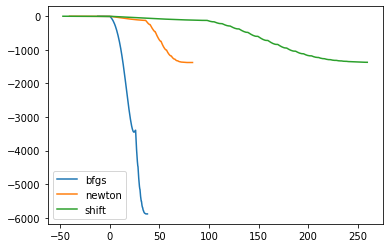

In [7]:
plt.plot(bfgs_vals[:, 1], bfgs_vals[:, 0], label="bfgs")
plt.plot(newton_vals[:, 1], newton_vals[:, 0], label="newton")
plt.plot(shift_vals[:, 1], shift_vals[:, 0], label="shift")
# plt.plot(shift_multi_vals[:, 1], shift_multi_vals[:, 0], label="shift_multi")

plt.legend()
# plt.ylim(-6000, -5500)
plt.show()

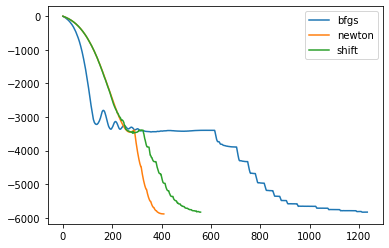

In [18]:
plt.plot(bfgs_vals[:, 0], label="bfgs")
plt.plot(newton_vals[:, 0], label="newton")
plt.plot(shift_vals[:, 0], label="shift")
# plt.plot(shift_multi_vals[:, 0], label="shift_multi")

plt.legend()
plt.show()

In [37]:
def path_distance(path1, path2):
    res = []
    if len(path1) < len(path2):
        shorter = path1
        longer = path2
    else:
        shorter = path2
        longer = path1
        
    longer_j = 0
    for i in range(len(shorter)):
        longer_j = i
#         print(longer_j)
        while ((longer_j + 1) < len(longer)) and (np.linalg.norm(shorter[i] - longer[longer_j]) > np.linalg.norm(shorter[i] - longer[longer_j+1])):
            longer_j += 1
        res.append(np.linalg.norm(shorter[i] - longer[longer_j]))
        if longer_j == len(longer) - 2:
            break
        
        
    for i in range(min(len(path1), len(path2))):
        res.append(np.linalg.norm(path1[i] - path2[i]))
    return res

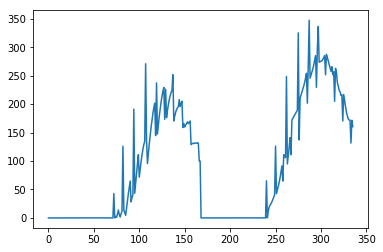

In [40]:
plt.plot(path_distance(shift_vals[:, 0], newton_vals[:, 0]))

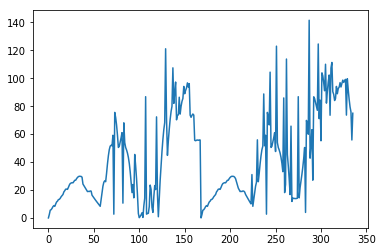

In [42]:
plt.plot(path_distance(bfgs_vals[:, 0], newton_vals[:, 0]))

In [29]:
t = 10
a = bfgs_path[t][-1][0]
# b = shift_path[t][-1][0]
# np.linalg.norm(a - b)

In [17]:
np.random.seed(10)
dim = 50
num_barriers = 2000
dirs = np.random.normal(size=(num_barriers, dim)) # sample gaussian and normalize 
ws = dirs/np.linalg.norm(dirs, axis=1).reshape(-1, 1)
bs = np.ones(num_barriers)


barrier = na.Barriers.LogPolytopeBarrier(ws, bs)

F = na.Functions.Linear(np.ones(dim))

F = barrier # na.Functions.LinearCombination(F, barrier, [1, 1])

In [59]:
est_hess = dfe.new_beta_second_shift_estimator(F, a[0], 200, 6000, control_variate=True)
true_hess = F.f2(np.array([a]))

est_inv_hess = np.linalg.inv(est_hess)
true_inv_hess = np.linalg.inv(true_hess)

In [60]:
np.linalg.norm(est_hess - true_hess)/np.linalg.norm(true_hess)

0.014561069440143938

In [61]:
np.linalg.norm(est_inv_hess - true_inv_hess)/np.linalg.norm(true_inv_hess)

0.022395838150512274

In [32]:
import time
x_0 = a[0]

times = []
alpha = 100
for i in range(1000, 5000, 100):
    a_time = time.time()
    dfe.multi_second_shift_estimator_task(x_0, F, i, alpha, [], [], 0, seed=0)
    times.append(time.time() - a_time)

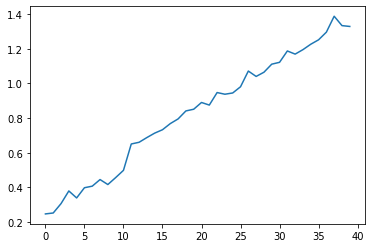

In [33]:
plt.plot(times)